In [510]:
import pandas as pd
import numpy as np
import json
import re
from plotnine import *
import plotnine


%matplotlib inline
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumBarunGothic'
plt.rcParams["font.size"] = 20
plt.rcParams["figure.figsize"] = (15,8)


# pandas max row 
pd.options.display.max_rows = 3000

In [511]:
b_unit = pd.read_csv('data/전유부.csv', dtype={
    '건물명':object, 
    '시군구코드': object, 
    '법정동코드' : object, 
    '층번호': np.int64, 
    '번' : object, 
    '지' : object, 
    '층구분코드': object 
    }
)

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.


In [512]:
b_unit['번'] = b_unit['번'].astype(str).str.zfill(4)
b_unit['지'] = b_unit['지'].astype(str).str.zfill(4)

b_unit['동'] = b_unit['대지주소'].str.replace('세종특별자치시 ',"")
b_unit['동'] = b_unit['동'].str.split(' ').str[1]

b_unit['PNU'] = b_unit['동'] + b_unit['번'] + b_unit['지']
b_unit.head()

,대지주소,시군구코드,법정동코드,동명칭,호명칭,층구분코드,층번호,면적(전용면적),건물명,번,지,용도코드명,주용도코드,기타용도,동,PNU
0,세종특별자치시 반곡동 4121-1002번지,36110,10100,주건축물제1동,101,20,1,3.2402,세종펠리스,4121,1002,일반음식점,4001,"일반음식점(기계,전기실)",반곡동,반곡동41211002
1,세종특별자치시 반곡동 4121-1002번지,36110,10100,주건축물제1동,101,20,1,39.3700,세종펠리스,4121,1002,일반음식점,4001,제2종근생(일반음식점),반곡동,반곡동41211002
2,세종특별자치시 반곡동 4121-1002번지,36110,10100,주건축물제1동,101,20,1,10.3346,세종펠리스,4121,1002,일반음식점,4001,"일반음식점(계단실,복도등)",반곡동,반곡동41211002
3,세종특별자치시 반곡동 4121-1002번지,36110,10100,주건축물제1동,101,20,1,33.6765,세종펠리스,4121,1002,일반음식점,4001,일반음식점(주차장),반곡동,반곡동41211002
4,세종특별자치시 반곡동 4121-1002번지,36110,10100,주건축물제1동,102,20,1,48.9500,세종펠리스,4121,1002,일반음식점,4001,제2종근생(일반음식점),반곡동,반곡동41211002


<AxesSubplot:>

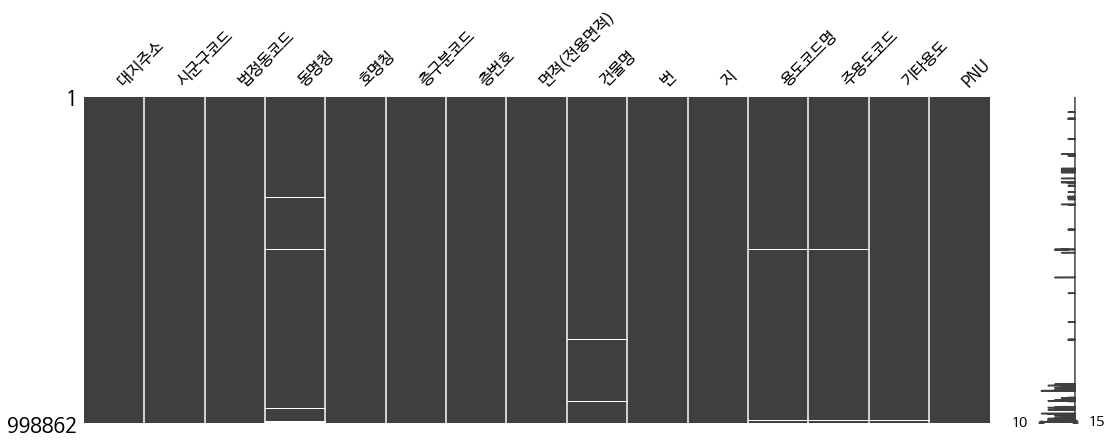

In [157]:
# 결측치 보기
import missingno as msno
msno.matrix(b_unit, figsize=(18,6))

### 아파트 건물 > 건물별 면적 > 3개월 평균 거래가

In [513]:
apt_unit = b_unit[b_unit['기타용도'].str.contains('아파트',na=False)]
apt_unit['기타용도'].unique()

array(['아파트', '공동주택(아파트)', '아파트 지하계단실', '아파트(도시형생활주택)',
       '아파트(도시형생활주택-원룸형)', '공둥주택(아파트)', '지하주차장,아파트동출입구', '사원아파트',
       '노인정(아파트)', '아파트 상가동', '아파트  상가동', '재동아파트상가', '아파트상가', '아파트상가내'],
      dtype=object)

In [515]:
#아파트 비해당 정보 제외
non_apt = ['지하','주차장','상가','노인정']
pattern = '|'.join(non_apt)
apt_unit = apt_unit.loc[~apt_unit['기타용도'].str.contains(pattern, case = False)]
apt_unit['기타용도'].unique()

array(['아파트', '공동주택(아파트)', '아파트(도시형생활주택)', '아파트(도시형생활주택-원룸형)',
       '공둥주택(아파트)', '사원아파트'], dtype=object)

In [516]:
#이름변경
apt_unit['건물명'] = apt_unit['건물명'].astype(str).str.replace('금남두진리버빌아파트','두진리버빌아파트')

In [517]:
# null값 drop(113893 >> 111907), 197
#apt_unit_without = apt_unit.dropna()
list_name = apt_unit['대지주소'].unique()
len(list_name)

197

In [560]:
#건물별 면적으로 groupping(1231)
apt_unit['면적(전용면적)'] = np.trunc(apt_unit['면적(전용면적)']).astype(float)
apt_group = apt_unit.groupby(['대지주소','면적(전용면적)']).agg({'동명칭' : 'count','건물명' : 'first','PNU' : 'first','법정동코드' : 'first'})
apt_group = apt_group.reset_index(level=[0,1])
apt_group['동'] = apt_group['대지주소'].str.replace('세종특별자치시 ',"")
apt_group['동'] = apt_group['동'].str.split(' ').str[1]
apt_group.head()

,대지주소,면적(전용면적),동명칭,건물명,PNU,법정동코드,동
0,세종특별자치시 고운동 1386번지,59.0,508,가락마을17단지,고운동13860000,11200,고운동
1,세종특별자치시 고운동 1387번지,84.0,263,가락마을22단지,고운동13870000,11200,고운동
2,세종특별자치시 고운동 1387번지,96.0,177,가락마을22단지,고운동13870000,11200,고운동
3,세종특별자치시 고운동 1390번지,84.0,268,가락마을21단지,고운동13900000,11200,고운동
4,세종특별자치시 고운동 1390번지,99.0,138,가락마을21단지,고운동13900000,11200,고운동


In [561]:
apt_trd = pd.read_csv('data/apt_trd.csv')
apt_trd['거래금액'] = apt_trd['거래금액'].str.replace(',','').astype(float)
apt_trd['아파트'] =apt_trd['아파트'].str.replace(' ','').astype(str)
apt_trd['전용면적'] = np.trunc(apt_trd['전용면적'])
apt_trd['월'] = apt_trd['월'].astype(str).str.zfill(2)
apt_trd['일'] = apt_trd['일'].astype(str).str.zfill(2)

apt_trd['계약일자'] = apt_trd['년'].astype(str) + apt_trd['월'] + apt_trd['일']
apt_trd['계약일자'] = pd.to_datetime(apt_trd['계약일자'], format='%Y%m%d')

apt_trd.head()

,Unnamed: 0,거래금액,건축년도,년,법정동,아파트,월,일,전용면적,지번,지역코드,층,해제사유발생일,해제여부,계약일자
0,0,36400.0,2016,2017,소담동,새샘마을9단지(중흥S클래스리버뷰),01,10,84.0,521,36110,5,NaN,NaN,2017-01-10
1,1,39282.0,2016,2017,소담동,새샘마을9단지(중흥S클래스리버뷰),01,20,84.0,521,36110,24,NaN,NaN,2017-01-20
2,2,49000.0,2016,2017,소담동,새샘마을3단지(모아미래도리버시티),01,21,97.0,BL-M3,36110,13,NaN,NaN,2017-01-21
3,3,40800.0,2016,2017,소담동,새샘마을3단지(모아미래도리버시티),01,25,97.0,BL-M3,36110,7,NaN,NaN,2017-01-25
4,4,8600.0,2016,2017,보람동,스타힐타워Ⅰ,01,01,16.0,743,36110,7,NaN,NaN,2017-01-01


In [562]:
# BL값 번지로 교체
apt_trd['지번'] = apt_trd['지번'].replace('BL-M3', 550)
apt_trd['지번'] = apt_trd['지번'].replace('BLH1', 738)
apt_trd['지번'] = apt_trd['지번'].replace('가-', 946)

In [563]:
#PNU코드 생성
apt_trd['번'] = apt_trd['지번'].astype(str).str.split('-').str[0]
apt_trd['지'] = apt_trd['지번'].astype(str).str.split('-').str[1]
apt_trd['번'] = apt_trd['번'].fillna(0)
apt_trd['지'] = apt_trd['지'].fillna(0)
apt_trd['번'] = apt_trd['번'].astype(str).str.zfill(4)
apt_trd['지'] = apt_trd['지'].astype(str).str.zfill(4)
apt_trd['PNU'] = apt_trd['법정동'].astype(str) + apt_trd['번'] + apt_trd['지']
apt_trd

,Unnamed: 0,거래금액,건축년도,년,법정동,아파트,월,일,전용면적,지번,지역코드,층,해제사유발생일,해제여부,계약일자,번,지,PNU
0,0,36400.0,2016,2017,소담동,새샘마을9단지(중흥S클래스리버뷰),01,10,84.0,521,36110,5,NaN,NaN,2017-01-10,0521,0000,소담동05210000
1,1,39282.0,2016,2017,소담동,새샘마을9단지(중흥S클래스리버뷰),01,20,84.0,521,36110,24,NaN,NaN,2017-01-20,0521,0000,소담동05210000
2,2,49000.0,2016,2017,소담동,새샘마을3단지(모아미래도리버시티),01,21,97.0,550,36110,13,NaN,NaN,2017-01-21,0550,0000,소담동05500000
3,3,40800.0,2016,2017,소담동,새샘마을3단지(모아미래도리버시티),01,25,97.0,550,36110,7,NaN,NaN,2017-01-25,0550,0000,소담동05500000
4,4,8600.0,2016,2017,보람동,스타힐타워Ⅰ,01,01,16.0,743,36110,7,NaN,NaN,2017-01-01,0743,0000,보람동07430000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24412,24412,7000.0,2001,2021,전의면 유천리,민석그린,02,18,59.0,528,36110,5,NaN,NaN,2021-02-18,0528,0000,전의면 유천리05280000
24413,24413,5200.0,1994,2021,전동면 노장리,도원,02,03,49.0,586,36110,5,NaN,NaN,2021-02-03,0586,0000,전동면 노장리05860000
24414,24414,5200.0,1994,2021,전동면 노장리,도원,02,23,49.0,586,36110,5,NaN,NaN,2021-02-23,0586,0000,전동면 노장리05860000
24415,24415,5000.0,1996,2021,소정면 운당리,무궁화,02,01,59.0,35-1,36110,7,NaN,NaN,2021-02-01,0035,0001,소정면 운당리00350001


In [564]:
#PNU기준으로 건물명 통일하기
PUN_col = ['PNU','아파트']
PNU = apt_trd[PUN_col].drop_duplicates()
PNU = PNU.set_index('PNU')
PNU = PNU.transpose()

PNU = PNU.to_dict()
PNU.get('한솔동09470000')

<ipython-input-564-2f30eebbc28c>:7: UserWarning: DataFrame columns are not unique, some columns will be omitted.


{'아파트': '첫마을3단지(퍼스트프라임)'}

In [565]:
# 건물명 채우기
for i in apt_group.index :
    pnu_value = apt_group['PNU'].iloc[i]
    apt_group['건물명'].iloc[i] = PNU.get(pnu_value)['아파트'] if pnu_value in PNU else apt_group['건물명'].iloc[i]

apt_group.tail()

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,대지주소,면적(전용면적),동명칭,건물명,PNU,법정동코드,동
727,세종특별자치시 해밀동 블록 행정중심복합도시 6-4생활권지구 M1블록블록,66.0,3,해밀마을2단지,해밀동00000000,11600,해밀동
728,세종특별자치시 해밀동 블록 행정중심복합도시 6-4생활권지구 M1블록블록,84.0,561,해밀마을2단지,해밀동00000000,11600,해밀동
729,세종특별자치시 해밀동 블록 행정중심복합도시 6-4생활권지구 M1블록블록,102.0,234,해밀마을2단지,해밀동00000000,11600,해밀동
730,세종특별자치시 해밀동 블록 행정중심복합도시 6-4생활권지구 M1블록블록,112.0,186,해밀마을2단지,해밀동00000000,11600,해밀동
731,세종특별자치시 해밀동 블록 행정중심복합도시 6-4생활권지구 M1블록블록,120.0,50,해밀마을2단지,해밀동00000000,11600,해밀동


In [566]:
list_mean = []
list_count = []

for i in apt_group.index :
    area = apt_group['면적(전용면적)'].loc[i]
    bid = apt_group['건물명'].loc[i]

    sample = apt_trd[apt_trd['전용면적'] == area]
    sample = sample[sample['아파트'].astype(str).str.contains(bid)]
    sample = sample.sort_values('계약일자', ascending = False)

    count_5 = sample.head(5)['거래금액'].count()
    mean_5 = sample.head(5)['거래금액'].mean()

    list_mean.append(mean_5)
    list_count.append(count_5)


apt_group['최근5건'] = list_mean
apt_group['최근5건수'] = list_count

C:\Anaconda\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\Anaconda\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\Anaconda\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\Anaconda\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\Anaconda\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\Anaconda\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\Anaconda\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actual

In [567]:
final = apt_group[~apt_group['최근5건'].isnull()]
final.tail()

,대지주소,면적(전용면적),동명칭,건물명,PNU,법정동코드,동,최근5건,최근5건수
710,세종특별자치시 해밀동 블록 행정중심복합도시 6-4 생활권지구 L1블록,59.0,930,해밀마을1단지,해밀동00000000,11600,해밀동,41670.000000,4
711,세종특별자치시 해밀동 블록 행정중심복합도시 6-4 생활권지구 L1블록,84.0,780,해밀마을1단지,해밀동00000000,11600,해밀동,84340.000000,5
713,세종특별자치시 해밀동 블록 행정중심복합도시 6-4 생활권지구 L1블록,120.0,100,해밀마을1단지,해밀동00000000,11600,해밀동,80000.000000,1
728,세종특별자치시 해밀동 블록 행정중심복합도시 6-4생활권지구 M1블록블록,84.0,561,해밀마을2단지,해밀동00000000,11600,해밀동,72200.000000,5
729,세종특별자치시 해밀동 블록 행정중심복합도시 6-4생활권지구 M1블록블록,102.0,234,해밀마을2단지,해밀동00000000,11600,해밀동,108333.333333,3


## KNN

In [557]:
from math import sqrt

# calculate the Euclidean distance between two vectors
# row = [x, y, type]
def euclidean_distance(row1, row2):
	distance = 0.0
	for i in range(len(row1)-1):
		distance += (row1[i] - row2[i])**2
	return sqrt(distance)

In [623]:
test_col = ['면적(전용면적)','동','최근5건','건물명']
test = final[test_col]
test = test.reset_index(drop = True)
test.tail()

,면적(전용면적),동,최근5건,건물명
155,59.0,해밀동,41670.000000,해밀마을1단지
156,84.0,해밀동,84340.000000,해밀마을1단지
157,120.0,해밀동,80000.000000,해밀마을1단지
158,84.0,해밀동,72200.000000,해밀마을2단지
159,102.0,해밀동,108333.333333,해밀마을2단지


In [624]:
from sklearn.model_selection import train_test_split
X_col = ['면적(전용면적)','최근5건']
X = test[X_col]
y = test['동']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [625]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)

In [626]:
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [628]:
print("테스트 세트 예측: {}".format(clf.predict(X_test)))

테스트 세트 예측: ['다정동' '다정동' '고운동' '고운동' '다정동' '다정동' '나성동' '도담동' '다정동' '어진동' '조치원읍' '다정동'
 '다정동' '다정동' '나성동' '다정동' '다정동' '새롬동' '나성동' '소담동' '소담동' '고운동' '다정동' '보람동'
 '다정동' '고운동' '다정동' '다정동' '도담동' '나성동' '다정동' '소담동' '다정동' '도담동' '보람동' '도담동'
 '조치원읍' '도담동' '도담동' '도담동']


In [629]:
print("테스트 세트 정확도: {:.2f}".format(clf.score(X_test, y_test)))

테스트 세트 정확도: 0.25


## 아파트 기타용도텍스트 카운팅

In [57]:
# 아파트 추출
apt_unit = b_unit[b_unit['용도코드명']=='아파트']

list_pur = apt_unit['기타용도'].str.split('(').str[0]
list_pur = list_pur.tolist()

list_pur01 = []
for i in list_pur:
    a = i.split(',')
    if len(a) == 1 :
        list_pur01.append(a[0])
    else :
        for i in range(len(a)) :
            list_pur01.append(a[i])


In [81]:
list_pur02 = pd.Series(list_pur01)
result = list_pur02.value_counts().head(5)
result

계단실      97471
아파트      92046
벽체       76238
지하주차장    59329
승강기      59102
dtype: int64